In [5]:
from openslide import OpenSlide
import scipy
import heapq
import numpy as np
import skimage as ski
import matplotlib.pyplot as plt
import os, sys
import math
import csv
from matplotlib_scalebar.scalebar import ScaleBar
import cv2

In [6]:
img_path = "D:\\Image Files\\Naa10Naa12 Cohort1 Histology\\"
keyWord = "_B3_Trichrome"
img_files = [os.path.join(img_path, img_file) for img_file in os.listdir(img_path) if keyWord.lower() in img_file.lower()]
print(img_files)

['D:\\Image Files\\Naa10Naa12 Cohort1 Histology\\GL25_001_B3_Trichrome.ndpi', 'D:\\Image Files\\Naa10Naa12 Cohort1 Histology\\GL25_002_B3_Trichrome.ndpi', 'D:\\Image Files\\Naa10Naa12 Cohort1 Histology\\GL25_003_B3_Trichrome.ndpi', 'D:\\Image Files\\Naa10Naa12 Cohort1 Histology\\GL25_004_B3_Trichrome.ndpi', 'D:\\Image Files\\Naa10Naa12 Cohort1 Histology\\GL25_006_B3_Trichrome.ndpi', 'D:\\Image Files\\Naa10Naa12 Cohort1 Histology\\GL25_007_B3_Trichrome.ndpi', 'D:\\Image Files\\Naa10Naa12 Cohort1 Histology\\GL25_008_B3_Trichrome.ndpi', 'D:\\Image Files\\Naa10Naa12 Cohort1 Histology\\GL25_014_B3_Trichrome.ndpi', 'D:\\Image Files\\Naa10Naa12 Cohort1 Histology\\GL25_015_B3_Trichrome.ndpi', 'D:\\Image Files\\Naa10Naa12 Cohort1 Histology\\GL25_022_B3_Trichrome.ndpi', 'D:\\Image Files\\Naa10Naa12 Cohort1 Histology\\GL25_023_B3_Trichrome.ndpi', 'D:\\Image Files\\Naa10Naa12 Cohort1 Histology\\GL25_027_B3_Trichrome.ndpi', 'D:\\Image Files\\Naa10Naa12 Cohort1 Histology\\GL25_028_B3_Trichrome.ndpi'

In [7]:
img_current = img_files[0]
print(img_current)

D:\Image Files\Naa10Naa12 Cohort1 Histology\GL25_001_B3_Trichrome.ndpi


In [8]:
img_slide = OpenSlide(img_current)

In [9]:
print(img_slide.dimensions)
print(img_slide.level_count)
print(img_slide.level_dimensions)
for prop in dict(img_slide.properties):
    print(prop+" - "+dict(img_slide.properties)[prop])
print(f"file size: {round(os.path.getsize(img_current) / 1024 ** 2, 2)} MB")

(69120, 14080)
8
((69120, 14080), (34560, 7040), (17280, 3520), (8640, 1760), (4320, 880), (2160, 440), (1080, 220), (540, 110))
hamamatsu.AHEX[0] - 0000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000
hamamatsu.AHEX[0].fluorescence - 0000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000
hamamatsu.AHEX[0].ploidy - 0000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000
hamamatsu.AHEX[1] - 000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000

In [10]:
?img_slide

Type:           OpenSlide
String form:    OpenSlide('D:\\Image Files\\Naa10Naa12 Cohort1 Histology\\GL25_001_B3_Trichrome.ndpi')
File:           c:\users\savile\appdata\local\miniforge3\envs\gpu-image-processing\lib\site-packages\openslide\__init__.py
Docstring:     
An open whole-slide image.

close() is called automatically when the object is deleted.
The object may be used as a context manager, in which case it will be
closed upon exiting the context.

If an operation fails, OpenSlideError is raised.  Note that OpenSlide
has latching error semantics: once OpenSlideError is raised, all future
operations on the OpenSlide object, other than close(), will fail.
Init docstring: Open a whole-slide image.

In [11]:
location = (0, 0)
level = img_slide.level_count-1
# size = (80, img_slide.level_dimensions[level][1])
size = img_slide.level_dimensions[level]
print(size)
region = img_slide.read_region(location, level, size)
# ?region

(540, 110)


In [12]:
np_region = np.asarray(region)
np_rgb = np_region[:, :, :3]
np_gray = ski.color.rgb2gray(np_rgb)
print(np_gray.shape)

(110, 540)


In [20]:
contours = ski.measure.find_contours(np_gray)

def calculate_contour_area(contour):
    x = contour[:, 1]  # X-coordinates
    y = contour[:, 0]  # Y-coordinates
    return 0.5 * np.abs(np.dot(x, np.roll(y, 1)) - np.dot(y, np.roll(x, 1)))

# Calculate areas for all contours
areas = [calculate_contour_area(contour) for contour in contours]
# areas.sort(reverse=True)
largest_indices = heapq.nlargest(3, range(len(areas)), key=lambda i: areas[i])
# print(largest_indices)

# Print areas
# for i, area in enumerate(areas):
#     print(f"Contour {i + 1}: Area = {area}")

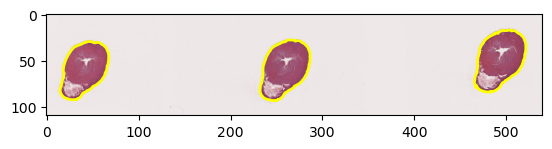

In [21]:
fig, ax = plt.subplots()
ax.imshow(np_rgb)

for index in largest_indices:
    ax.plot(contours[index][:, 1], contours[index][:, 0], linewidth=2, color='yellow')

plt.show()
# print(contours)

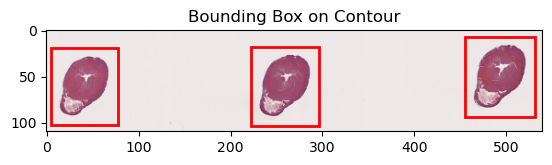

In [22]:
coordinates = []
# Display the bounding box on the image
fig, ax = plt.subplots()
ax.imshow(np_rgb)
for index in largest_indices:
    # Calculate the bounding box
    x_min, x_max = np.min(contours[index][:, 1])-10, np.max(contours[index][:, 1])+10
    y_min, y_max = np.min(contours[index][:, 0])-10, np.max(contours[index][:, 0])+10
    # ax.plot(contours[index][:, 1], contours[index][:, 0], linewidth=2, color='yellow')
    location = (x_min, y_min)
    size = (x_max-x_min, y_max-y_min)
    coordinates.append([location, size])
    rect = plt.Rectangle((x_min, y_min), x_max - x_min, y_max - y_min,
                     linewidth=2, edgecolor='red', facecolor='none')  # Bounding box
    ax.add_patch(rect)
    
ax.set_title('Bounding Box on Contour')
plt.show()

In [23]:
#Scale bounding boxes up to original image, crop hearts, save
downsample_factor = img_slide.level_downsamples[level]
higher_bounding_boxes = []

for box in coordinates:
    bigger_box = []
    for coord in box:
        new_box = (int(downsample_factor*coord[0]), int(downsample_factor*coord[1]))
        bigger_box.append(new_box)
    higher_bounding_boxes.append(bigger_box)

print(len(higher_bounding_boxes))

3


In [24]:
highest_region = img_slide.read_region(higher_bounding_boxes[0][0], 0, higher_bounding_boxes[0][1])
np_region = np.asarray(highest_region)
np_rgb = np_region[:, :, :3]

print(np_rgb.shape)

(11219, 9725, 3)


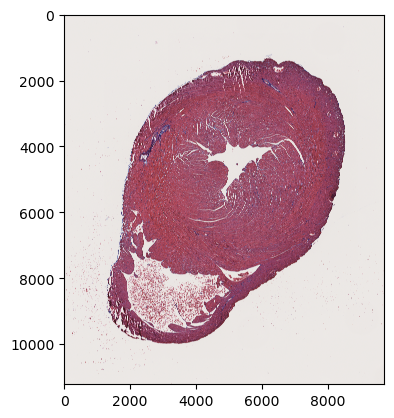

In [25]:
fig, ax = plt.subplots()
ax.imshow(np_rgb)

plt.show()

In [26]:
# Threshold red color
img_hsv = ski.color.rgb2hsv(np_rgb)

In [48]:
lower1 = np.array([0, 25/255, 20/255])
lower2 = np.array([300/360, 25/255, 20/255])

upper1 = np.array([10/360, 1, 1])
upper2 = np.array([1, 1, 1])

mask1 = np.all((img_hsv >= lower1) & (img_hsv <= upper1), axis=-1)
mask2 = np.all((img_hsv >= lower2) & (img_hsv <= upper2), axis=-1)

img_red = np_rgb * mask1[:, :, np.newaxis] + np_rgb *mask2[:, :, np.newaxis]

black_pixels = (img_red[:, :, 0] == 0) & (img_red[:, :, 1] == 0) & (img_red[:, :, 2] == 0)
img_red[black_pixels] = [255, 255, 255]

In [49]:
lower_hue = 0.5 #121/255
lower_sat = 25/255 #20/255
lower_bri = 20/255 #10/255

upper_hue = 0.7 #179/255
upper_sat = 1
upper_bri = 1

lower_bound = np.array([lower_hue, lower_sat, lower_bri])
upper_bound = np.array([upper_hue, upper_sat, upper_bri])

img_mask = np.all((img_hsv >= lower_bound) & (img_hsv <= upper_bound), axis=-1)
img_blue = np_rgb * img_mask[:, :, np.newaxis]

black_pixels = (img_blue[:, :, 0] == 0) & (img_blue[:, :, 1] == 0) & (img_blue[:, :, 2] == 0)
img_blue[black_pixels] = [255, 255, 255]
# binary_mask = np.zeros_like(np_rgb[:, :, 0])
# binary_mask[img_mask] = 255

In [19]:
print(img_mask.shape)
print(binary_mask.shape)

(11467, 11073)
(11467, 11073)


File Saved!


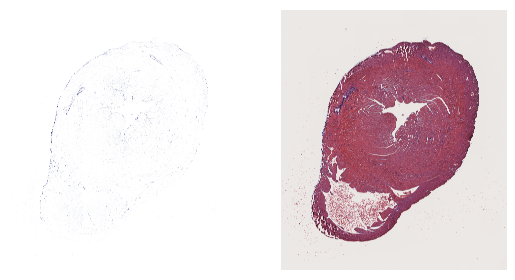

In [50]:
fig, ax = plt.subplots(1, 2)

ax[0].imshow(img_blue)#, cmap='gray')
ax[1].imshow(np_rgb)

# Remove axes for cleaner display
for a in ax.flatten():
    a.axis('off')
    
plt.savefig("Test Trichrome Blue Output.png", dpi=5000)
print("File Saved!")
plt.show()

File Saved!


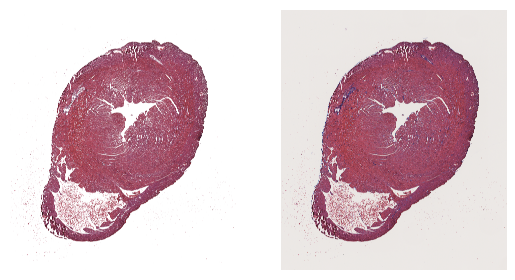

In [51]:
fig, ax = plt.subplots(1, 2)

ax[0].imshow(img_red)#, cmap='gray')
ax[1].imshow(np_rgb)

# Remove axes for cleaner display
for a in ax.flatten():
    a.axis('off')
    
plt.savefig("Test Trichrome Red Output.png", dpi=5000)
print("File Saved!")
plt.show()

In [3]:
def trim_after_char(text, char):
    index = text.rindex(char)
    if index != -1:
        return text[index+1:]
    return text

def calculate_contour_area(contour):
    x = contour[:, 1]  # X-coordinates
    y = contour[:, 0]  # Y-coordinates
    return 0.5 * np.abs(np.dot(x, np.roll(y, 1)) - np.dot(y, np.roll(x, 1)))

for img in img_files:
    img_slide = OpenSlide(img)
    print("Slide - "+trim_after_char(img, "\\")+" - Loaded")
    
    location = (0, 0)
    level = img_slide.level_count-1
    size = img_slide.level_dimensions[level]
    region = img_slide.read_region(location, level, size)

    np_region = np.asarray(region)
    np_rgb = np_region[:, :, :3]
    np_gray = ski.color.rgb2gray(np_rgb)
    contours = ski.measure.find_contours(np_gray)
    # Calculate areas for all contours
    areas = [calculate_contour_area(contour) for contour in contours]
    largest_indices = heapq.nlargest(3, range(len(areas)), key=lambda i: areas[i])

    coordinates = []
    for index in largest_indices:
        # Calculate the bounding box
        x_min, x_max = np.min(contours[index][:, 1])-10, np.max(contours[index][:, 1])+10
        y_min, y_max = np.min(contours[index][:, 0])-10, np.max(contours[index][:, 0])+10
        
        location = (x_min, y_min)
        size = (x_max-x_min, y_max-y_min)
        coordinates.append([location, size])

    downsample_factor = img_slide.level_downsamples[level]
    higher_bounding_boxes = []
    
    for box in coordinates:
        bigger_box = []
        for coord in box:
            new_box = (int(downsample_factor*coord[0]), int(downsample_factor*coord[1]))
            bigger_box.append(new_box)
        higher_bounding_boxes.append(bigger_box)

    
    lower_hue = 0.5 #121/255
    lower_sat = 25/255 #20/255
    lower_bri = 20/255 #10/255
    upper_hue = 0.7 #179/255
    upper_sat = 1
    upper_bri = 1

    lower_bound = np.array([lower_hue, lower_sat, lower_bri])
    upper_bound = np.array([upper_hue, upper_sat, upper_bri])

    for i, boxes in enumerate(higher_bounding_boxes):
        highest_region = img_slide.read_region(boxes[0], 0, boxes[1])
        np_region = np.asarray(highest_region)
        np_rgb = np_region[:, :, :3]
    
        img_hsv = ski.color.rgb2hsv(np_rgb)

        img_mask = np.all((img_hsv >= lower_bound) & (img_hsv <= upper_bound), axis=-1)
        binary_mask = np.zeros_like(np_rgb[:, :, 0])
        binary_mask[img_mask] = 255

        fig, ax = plt.subplots()
        ax.axis('off')
        plt.imshow(binary_mask, cmap="Blues")
        plt.savefig(trim_after_char(img, "\\")+" Heart - "+str(i+1)+".png", dpi=5000)
        plt.close()
        print("File Generated!")

Slide - GL25_001_B3_Trichrome.ndpi - Loaded
File Generated!
File Generated!
File Generated!
Slide - GL25_002_B3_Trichrome.ndpi - Loaded
File Generated!
File Generated!
File Generated!
Slide - GL25_003_B3_Trichrome.ndpi - Loaded
File Generated!
File Generated!
File Generated!
Slide - GL25_004_B3_Trichrome.ndpi - Loaded
File Generated!
File Generated!
File Generated!
Slide - GL25_006_B3_Trichrome.ndpi - Loaded
File Generated!
File Generated!
File Generated!
Slide - GL25_007_B3_Trichrome.ndpi - Loaded
File Generated!
File Generated!
File Generated!
Slide - GL25_008_B3_Trichrome.ndpi - Loaded
File Generated!
File Generated!
File Generated!
Slide - GL25_014_B3_Trichrome.ndpi - Loaded
File Generated!
File Generated!
File Generated!
Slide - GL25_015_B3_Trichrome.ndpi - Loaded
File Generated!
File Generated!
File Generated!
Slide - GL25_022_B3_Trichrome.ndpi - Loaded
File Generated!
File Generated!
File Generated!
Slide - GL25_023_B3_Trichrome.ndpi - Loaded
File Generated!
File Generated!
File

In [24]:
plt.close('all')